In [6]:
dataDir = "/home/ababil/BUET/AV/location-2"     # Ababil
# dataDir = "D:/AV/Code/location-2"               # Pushpita
dataDir = "D:/AV/DataSetExploration/drone-dataset-tools/data/location-2"

In [7]:
exec(open('init_notebook.py').read())

FileNotFoundError: [Errno 2] No such file or directory: 'init_notebook.py'

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from tti_dataset_tools.ColMapper import ColMapper

### Scenes 
| Scene | Min Y | Max X |
|-------|-------|-------|
| 210   | 5     | 6     |
| 211   | 5     | 6     |
| 220   | 6     | 6     |
| 221   | 9     | 6     |
| 222   | 9     | 6     |
| 230   | 6     | 6     |
| 231   | 2     | 6     |
| 240   | 6     | 6     |

- What does minYDisplacement and maxXDisplacement mean? 


In [19]:
sceneId = 222
date = "2023-05-04"
fps=10
minYDisplacement = 6
maxXDisplacement = 6
pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
otherDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-others.csv"))
tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))

In [20]:
# # unique of roadWidth
# print(pedDf['roadWidth'].unique())

# pedDf

In [22]:
visualizer = TrajectoryVisualizer()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='sceneX', 
        yCol='sceneY',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity', 
        speedCol='speed',
        xAccCol='sceneXAcceleration',
        yAccCol='sceneYAcceleration',
        accelerationCol='acceleration'
    )
transformer = TrajectoryTransformer(colMapper)
cleaner = TrajectoryCleaner(
    colMapper = colMapper,
    minSpeed = 0.0, # we can consider them as obstacles
    maxSpeed = 3.5,
    minAcceleration = -10.0,
    maxAcceleration = 10.0,
    minYDisplacement = minYDisplacement,
    maxXDisplacement = maxXDisplacement
)
transformer.deriveAxisVelocities(pedDf)
transformer.deriveSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
transformer.deriveAcceleration(pedDf)

plt.boxplot(pedDf['displacementY'])
plt.show()
plt.boxplot(pedDf['speed'])
plt.show()

AttributeError: 'TrajectoryTransformer' object has no attribute 'deriveAxisVelocities'

In [16]:
cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)

# visualizer.show(pedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
# visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
transformer.translateAllToLocalSource(cleanPedDf)

southIds = []
for pedId in allPedIds:
    trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
    trackMeta = tracksMeta[tracksMeta["uniqueTrackId"] == pedId].iloc[0]
    # print(trackMeta['verticalDirection'])
    if trackMeta['verticalDirection'] == "SOUTH":
        southIds.append(pedId)
        # print(trackMeta["uniqueTrackId"])
        X, Y = transformer.rotate(trackDf)
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localX'] = X
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localY'] = Y
len(cleanPedDf)


using min Y displacement (6)


3643

Check the trajectories by visualizing the scenes, and the dataframe.

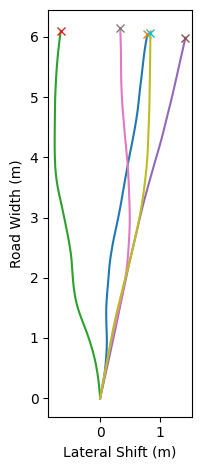

In [173]:
visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')

In [174]:
cleanPedDf

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY
1701,21,340,21003,240,6.0,2.122808,2.922780,0.144132,0.704056,-0.002516,-0.185806,0.718658,2.149189,0.040427,0.185823,-0.000000,-0.000000
1702,21,342,21003,240,6.0,2.093242,2.779816,0.147831,0.714821,-0.018494,-0.053825,0.729947,2.119623,0.102537,0.056913,0.029566,0.142964
1703,21,344,21003,240,6.0,2.067285,2.634641,0.129785,0.725876,0.090231,-0.055276,0.737387,2.093666,0.247712,0.105816,0.055523,0.288139
1704,21,346,21003,240,6.0,2.045431,2.487554,0.109271,0.735435,0.102572,-0.047795,0.743508,2.071811,0.394799,0.113161,0.077377,0.435226
1705,21,348,21003,240,6.0,2.029394,2.339475,0.080186,0.740394,0.145424,-0.024796,0.744724,2.055774,0.542878,0.147523,0.093414,0.583305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6257,26,25377,26437,240,6.0,-0.860836,-2.569047,0.011542,0.713318,0.000976,0.018743,0.713412,0.834455,5.451400,0.018768,0.829147,5.506991
6258,26,25379,26437,240,6.0,-0.862640,-2.708986,0.009023,0.699695,0.012596,0.068117,0.699753,0.836260,5.591339,0.069272,0.830952,5.646930
6259,26,25381,26437,240,6.0,-0.864081,-2.846484,0.007204,0.687489,0.009092,0.061030,0.687527,0.837701,5.728837,0.061703,0.832392,5.784428
6260,26,25383,26437,240,6.0,-0.865253,-2.982461,0.005860,0.679881,0.006722,0.038038,0.679907,0.838873,5.864814,0.038627,0.833564,5.920404


In [175]:
# number of unique pedestrians
len(cleanPedDf["uniqueTrackId"].unique())

5

In [176]:
# max and min values of speed
print(cleanPedDf['speed'].max())
print(cleanPedDf['speed'].min())



1.0359868170010624
0.5197303844302296
